In [1]:
!pip install torch torchvision timm scikit-learn matplotlib pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import timm
import numpy as np
from PIL import Image
from google.colab import files

# Rastgelelik için sabit tohum
torch.manual_seed(42)
np.random.seed(42)

# Veri yolu (Google Drive'daki veri klasörünüzü buraya yazın)
DATASET_PATH = '/content/drive/MyDrive/data'  # Örnek yol, kendi yolunuzla değiştirin
TRAIN_PATH = os.path.join(DATASET_PATH, "train")

# Veri yollarının varlığını kontrol et
if not os.path.exists(TRAIN_PATH):
    raise FileNotFoundError(f"Eğitim veri yolu bulunamadı: {TRAIN_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Eğitim dönüşümleri
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Doğrulama dönüşümleri
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Verisetini yükle
try:
    train_dataset = ImageFolder(TRAIN_PATH, transform=train_transforms)
except Exception as e:
    raise Exception(f"Eğitim verisetini yüklerken hata: {e}")

# Eğitim ve doğrulama için veri ayırma (80% eğitim, 20% doğrulama)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Veri yükleyiciler
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

In [ ]:
# Model kurulumu (Vision Transformer)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=len(train_dataset.classes))
model = model.to(device)

# Hiperparametreler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 20
patience = 5

# Erken durdurma değişkenleri
best_val_loss = float("inf")
patience_counter = 0
best_model_path = "best_vit_model.pth"

In [ ]:
# Eğitim ve doğrulama için listeler
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Eğitim
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Doğrulama
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Erken durdurma
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Erken durdurma tetiklendi")
            break

Epoch 1/25, Train Loss: 1.0065, Train Acc: 0.7399, Val Loss: 0.1938, Val Acc: 0.9403
Epoch 2/25, Train Loss: 0.1439, Train Acc: 0.9579, Val Loss: 0.2333, Val Acc: 0.9328
Epoch 3/25, Train Loss: 0.0888, Train Acc: 0.9794, Val Loss: 0.4045, Val Acc: 0.8955
Epoch 4/25, Train Loss: 0.0662, Train Acc: 0.9832, Val Loss: 0.2129, Val Acc: 0.9328
Epoch 5/25, Train Loss: 0.0311, Train Acc: 0.9897, Val Loss: 0.2743, Val Acc: 0.9403
Epoch 6/25, Train Loss: 0.0313, Train Acc: 0.9897, Val Loss: 0.2459, Val Acc: 0.9440
Epoch 7/25, Train Loss: 0.1031, Train Acc: 0.9747, Val Loss: 0.3306, Val Acc: 0.9142
Epoch 8/25, Train Loss: 0.0711, Train Acc: 0.9785, Val Loss: 0.4182, Val Acc: 0.8993
Epoch 9/25, Train Loss: 0.0575, Train Acc: 0.9804, Val Loss: 0.5087, Val Acc: 0.8843
Epoch 10/25, Train Loss: 0.0420, Train Acc: 0.9869, Val Loss: 0.3888, Val Acc: 0.8918


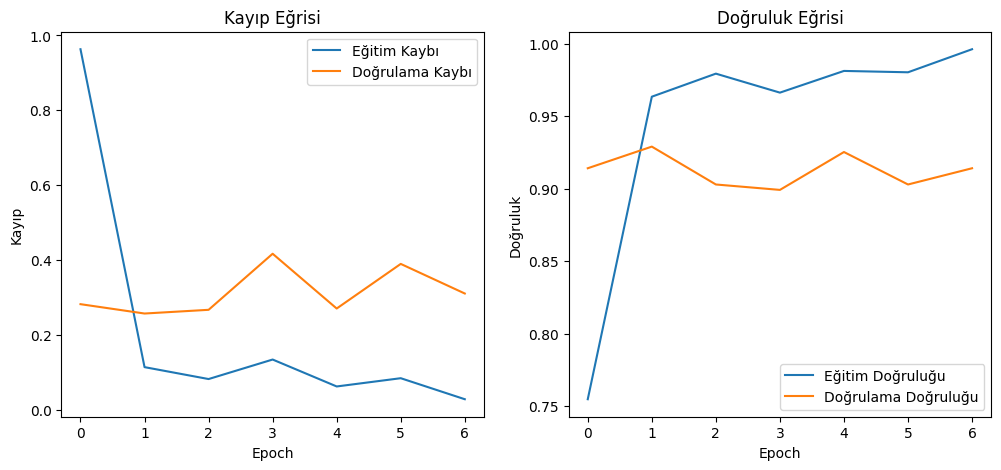

In [10]:
# En iyi modeli yükle
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Öğrenme eğrilerini çiz
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Eğitim Kaybı")
plt.plot(val_losses, label="Doğrulama Kaybı")
plt.xlabel("Epoch")
plt.ylabel("Kayıp")
plt.legend()
plt.title("Kayıp Eğrisi")
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Eğitim Doğruluğu")
plt.plot(val_accuracies, label="Doğrulama Doğruluğu")
plt.xlabel("Epoch")
plt.ylabel("Doğruluk")
plt.legend()
plt.title("Doğruluk Eğrisi")
plt.savefig("learning_curves.png")
plt.show()

Lütfen sınıflandırmak istediğiniz görüntüyü yükleyin:


Saving indir.jpeg to indir.jpeg
Tahmin: dragonfly
Güven Skoru: 21.11%


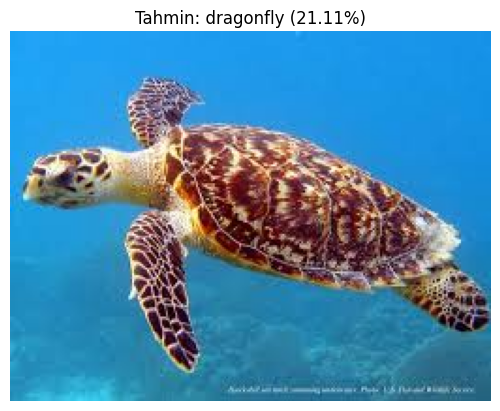

In [13]:
# Görüntü sınıflandırma fonksiyonu
def classify_image():
    print("Lütfen sınıflandırmak istediğiniz görüntüyü yükleyin:")
    uploaded = files.upload()
    for file_name in uploaded.keys():
        image = Image.open(file_name).convert("RGB")
        image_tensor = val_transforms(image).unsqueeze(0).to(device)

        model.eval()
        with torch.no_grad():
            output = model(image_tensor)
            probabilities = torch.softmax(output, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
            predicted_class = train_dataset.classes[predicted.item()]
            confidence_score = confidence.item() * 100

        print(f"Tahmin: {predicted_class}\nGüven Skoru: {confidence_score:.2f}%")
        plt.imshow(image)
        plt.title(f"Tahmin: {predicted_class} ({confidence_score:.2f}%)")
        plt.axis('off')
        plt.show()

# Sınıflandırmayı başlat
classify_image()